In [12]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv
import re
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

# Load environment variables and set OpenAI API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [2]:
# State Definition
# This cell defines the State class, which represents the state of our grading process.

class State(TypedDict):
    """Represents the state of the essay grading process."""
    essay: str
    relevance_score: float
    grammar_score: float
    structure_score: float
    depth_score: float
    final_score: float

In [3]:
# Language Model Initialization
# This cell initializes the ChatOpenAI model.

# Initialize the ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
# Grading Functions
# This cell defines the functions used in the grading process, including score extraction and individual grading components.

def extract_score(content: str) -> float:
    """Extract the numeric score from the LLM's response."""
    match = re.search(r'Score:\s*(\d+(\.\d+)?)', content)
    if match:
        return float(match.group(1))
    raise ValueError(f"Could not extract score from: {content}")

def check_relevance(state: State) -> State:
    """Check the relevance of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the relevance of the following essay to the given topic. "
        "Provide a relevance score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["relevance_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in check_relevance: {e}")
        state["relevance_score"] = 0.0
    return state

def check_grammar(state: State) -> State:
    """Check the grammar of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the grammar and language usage in the following essay. "
        "Provide a grammar score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["grammar_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in check_grammar: {e}")
        state["grammar_score"] = 0.0
    return state

def analyze_structure(state: State) -> State:
    """Analyze the structure of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the structure of the following essay. "
        "Provide a structure score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["structure_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in analyze_structure: {e}")
        state["structure_score"] = 0.0
    return state

def evaluate_depth(state: State) -> State:
    """Evaluate the depth of analysis in the essay."""
    prompt = ChatPromptTemplate.from_template(
        "Evaluate the depth of analysis in the following essay. "
        "Provide a depth score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"]))
    try:
        state["depth_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in evaluate_depth: {e}")
        state["depth_score"] = 0.0
    return state

def calculate_final_score(state: State) -> State:
    """Calculate the final score based on individual component scores."""
    state["final_score"] = (
        state["relevance_score"] * 0.3 +
        state["grammar_score"] * 0.2 +
        state["structure_score"] * 0.2 +
        state["depth_score"] * 0.3
    )
    return state

In [5]:
# Workflow Definition
# This cell defines the grading workflow using StateGraph.

# Initialize the StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("check_grammar", check_grammar)
workflow.add_node("analyze_structure", analyze_structure)
workflow.add_node("evaluate_depth", evaluate_depth)
workflow.add_node("calculate_final_score", calculate_final_score)

# Define and add conditional edges
workflow.add_conditional_edges(
    "check_relevance",
    lambda x: "check_grammar" if x["relevance_score"] > 0.5 else "calculate_final_score"
)
workflow.add_conditional_edges(
    "check_grammar",
    lambda x: "analyze_structure" if x["grammar_score"] > 0.6 else "calculate_final_score"
)
workflow.add_conditional_edges(
    "analyze_structure",
    lambda x: "evaluate_depth" if x["structure_score"] > 0.7 else "calculate_final_score"
)
workflow.add_conditional_edges(
    "evaluate_depth",
    lambda x: "calculate_final_score"
)

# Set the entry point
workflow.set_entry_point("check_relevance")

# Set the exit point
workflow.add_edge("calculate_final_score", END)

# Compile the graph
app = workflow.compile()

In [6]:
# Essay Grading Function
# This cell defines the main function to grade an essay using the defined workflow.

def grade_essay(essay: str) -> dict:
    """Grade the given essay using the defined workflow."""
    initial_state = State(
        essay=essay,
        relevance_score=0.0,
        grammar_score=0.0,
        structure_score=0.0,
        depth_score=0.0,
        final_score=0.0
    )
    result = app.invoke(initial_state)
    return result

In [7]:
# Sample Essay
# This cell contains a sample essay for testing the grading system.

sample_essay = """
    The Impact of Artificial Intelligence on Modern Society

    Artificial Intelligence (AI) has become an integral part of our daily lives, 
    revolutionizing various sectors including healthcare, finance, and transportation. 
    This essay explores the profound effects of AI on modern society, discussing both 
    its benefits and potential challenges.

    One of the most significant impacts of AI is in the healthcare industry. 
    AI-powered diagnostic tools can analyze medical images with high accuracy, 
    often surpassing human capabilities. This leads to earlier detection of diseases 
    and more effective treatment plans. Moreover, AI algorithms can process vast 
    amounts of medical data to identify patterns and insights that might escape 
    human observation, potentially leading to breakthroughs in drug discovery and 
    personalized medicine.

    In the financial sector, AI has transformed the way transactions are processed 
    and monitored. Machine learning algorithms can detect fraudulent activities in 
    real-time, enhancing security for consumers and institutions alike. Robo-advisors 
    use AI to provide personalized investment advice, democratizing access to 
    financial planning services.

    The transportation industry is another area where AI is making significant strides. 
    Self-driving cars, powered by complex AI systems, promise to reduce accidents 
    caused by human error and provide mobility solutions for those unable to drive. 
    In logistics, AI optimizes routing and inventory management, leading to more 
    efficient supply chains and reduced environmental impact.

    However, the rapid advancement of AI also presents challenges. There are concerns 
    about job displacement as AI systems become capable of performing tasks 
    traditionally done by humans. This raises questions about the need for retraining 
    and reskilling the workforce to adapt to an AI-driven economy.

    Privacy and ethical concerns also arise with the increasing use of AI. The vast 
    amount of data required to train AI systems raises questions about data privacy 
    and consent. Additionally, there are ongoing debates about the potential biases 
    in AI algorithms and the need for transparent and accountable AI systems.

    In conclusion, while AI offers tremendous benefits and has the potential to solve 
    some of humanity's most pressing challenges, it also requires careful consideration 
    of its societal implications. As we continue to integrate AI into various aspects 
    of our lives, it is crucial to strike a balance between technological advancement 
    and ethical considerations, ensuring that the benefits of AI are distributed 
    equitably across society.
    """

In [8]:
# Grading the Sample Essay
# This cell demonstrates how to use the grading system on the sample essay and display the results.

# Grade the sample essay
result = grade_essay(sample_essay)

# Display the results
print(f"Final Essay Score: {result['final_score']:.2f}\n")
print(f"Relevance Score: {result['relevance_score']:.2f}")
print(f"Grammar Score: {result['grammar_score']:.2f}")
print(f"Structure Score: {result['structure_score']:.2f}")
print(f"Depth Score: {result['depth_score']:.2f}")

Final Essay Score: 0.87

Relevance Score: 1.00
Grammar Score: 0.90
Structure Score: 0.90
Depth Score: 0.70


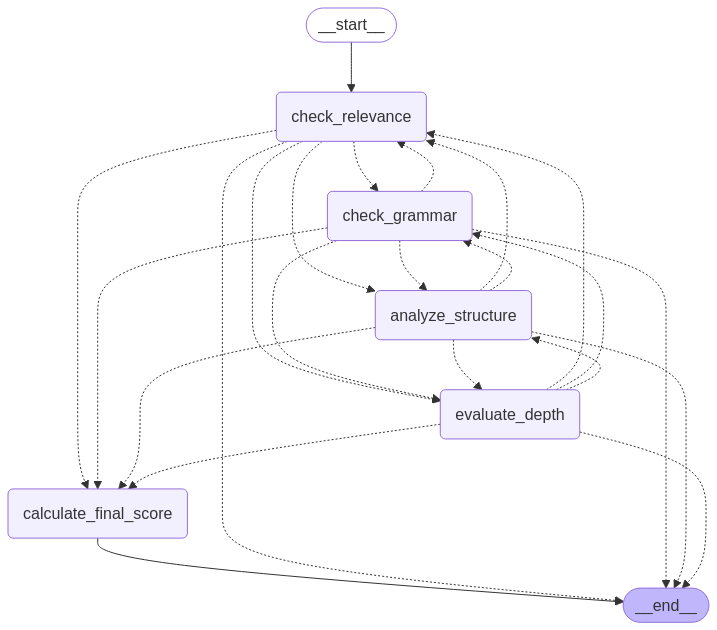

In [13]:
# Visualize the Graph
# This cell generates and displays a visual representation of our LangGraph workflow.

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)